In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import warnings

from sklearn.preprocessing import LabelEncoder, FunctionTransformer, label_binarize
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import SVC
from sklearn.model_selection import (
    train_test_split,
    learning_curve,
    RandomizedSearchCV
)
from sklearn.pipeline import Pipeline
from sklearn.metrics import (
    accuracy_score,
    precision_recall_fscore_support,
    roc_auc_score,
    confusion_matrix,
    classification_report,
    roc_curve,
    precision_recall_curve
)
from sklearn.calibration import calibration_curve
from sklearn.inspection import permutation_importance

from lime.lime_text import LimeTextExplainer
from IPython.display import HTML, display

from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE

warnings.filterwarnings('ignore')
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

Classes: ['Anxiety' 'Depression' 'Normal']
Counts:
 y
2    1019
1     800
0     798
Name: count, dtype: int64 



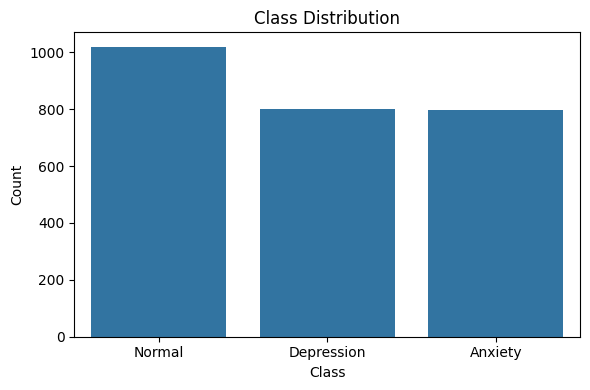

In [2]:
# Load & Label-Encode Data + Class Distribution
df = pd.read_csv("../Data/Preprocessed_Manual_Labelled_Dataset .csv")
df['text'] = (df['cleaned_text']
                .astype(str)
                .str.replace(r'\s+', ' ', regex=True)
                .str.strip())

le = LabelEncoder()
df['y'] = le.fit_transform(df['label'])

print("Classes:", le.classes_)
print("Counts:\n", df['y'].value_counts(), "\n")

plt.figure(figsize=(6,4))
sns.barplot(
    x=df['label'].value_counts().index,
    y=df['label'].value_counts().values
)
plt.title('Class Distribution')
plt.xlabel('Class'); plt.ylabel('Count')
plt.tight_layout(); plt.show()


In [3]:
# Define Stemmer + Transformer
COMMON_SUFFIXES = [
    'වූ','වෙන','වෙයි','වුණ','න්න','නුම්',
    'වී','යේ','යුතු','පුළුවන්','කරන','කරයි',
    'හු','වරු','ලා','වල්','ගේ','ට','ගෙන්','ළඟ',
    'එක','යි','ද','ක්','ම','ටයි','තුමා'
]

def stem_and_join(text: str) -> str:
    tokens, stems = text.split(), []
    for tok in tokens:
        stem = tok
        for suf in COMMON_SUFFIXES:
            if stem.endswith(suf) and len(stem) - len(suf) >= 2:
                stem = stem[:-len(suf)]
                break
        stems.append(stem)
    return " ".join(stems)

def transform_stems(X):
    return [stem_and_join(x) for x in X]


In [4]:
# Train/Test Split (raw & stemmed)
X_raw     = df['text']
X_stemmed = df['text'].map(stem_and_join)
y         = df['y']

X_tr_raw, X_te_raw, X_tr_stem, X_te_stem, y_train, y_test = train_test_split(
    X_raw, X_stemmed, y,
    test_size=0.20,
    stratify=y,
    random_state=RANDOM_STATE
)
print(f"Train: {len(X_tr_raw)} raw, {len(X_tr_stem)} stemmed")
print(f"Test : {len(X_te_raw)} raw, {len(X_te_stem)} stemmed\n")

Train: 2093 raw, 2093 stemmed
Test : 524 raw, 524 stemmed



In [5]:
# Precompute TF-IDF Features (tokens ≥ 3 chars)
TFIDF_ARGS = dict(
    token_pattern=r'(?u)\b\w{3,}\b',
    ngram_range=(1,2),
    max_features=3000,
    sublinear_tf=True
)

tfidf = TfidfVectorizer(**TFIDF_ARGS)
X_tr_tfidf = tfidf.fit_transform(X_tr_stem)
X_te_tfidf = tfidf.transform(X_te_stem)

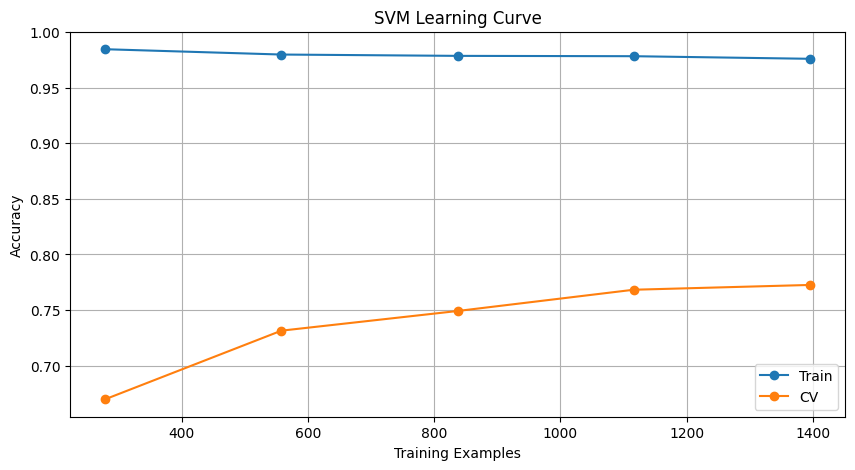

In [6]:
# Learning-Curve Helper
def plot_learning_curve(estimator, X, y, cv=3, title="Learning Curve"):
    from sklearn.model_selection import learning_curve as lc
    train_sizes, train_scores, val_scores = lc(
        estimator, X, y,
        train_sizes=np.linspace(0.2,1.0,5),
        cv=cv, scoring='accuracy',
        shuffle=True, random_state=RANDOM_STATE, n_jobs=-1
    )
    plt.figure(figsize=(10,5))
    plt.plot(train_sizes, train_scores.mean(axis=1), 'o-', label='Train')
    plt.plot(train_sizes, val_scores.mean(axis=1),   'o-', label='CV')
    plt.title(title)
    plt.xlabel("Training Examples"); plt.ylabel("Accuracy")
    plt.legend(); plt.grid(True); plt.show()

# Baseline SVM Learning Curve
baseline_svm = Pipeline([
    ('stem',  FunctionTransformer(transform_stems, validate=False)),
    ('tfidf', TfidfVectorizer(**TFIDF_ARGS)),
    ('clf',   SVC(probability=True, class_weight='balanced', random_state=RANDOM_STATE))
])
plot_learning_curve(baseline_svm, X_tr_raw, y_train, cv=3,
                    title="SVM Learning Curve")

In [7]:
# RandomizedSearchCV with SMOTE toggle
pipe = ImbPipeline([
    ('stem',  FunctionTransformer(transform_stems, validate=False)),
    ('tfidf', TfidfVectorizer(**TFIDF_ARGS)),
    ('smote', SMOTE(random_state=RANDOM_STATE)),
    ('clf',   SVC(probability=True, class_weight='balanced', random_state=RANDOM_STATE))
])

param_dist = {
    'smote':             [SMOTE(random_state=RANDOM_STATE), 'passthrough'],
    'clf__C':            [0.1, 1, 10],
    'clf__kernel':       ['linear', 'rbf'],
    'clf__gamma':        ['scale', 'auto']
}

search = RandomizedSearchCV(
    pipe,
    param_distributions=param_dist,
    n_iter=20, cv=3,
    scoring='f1_weighted',
    n_jobs=-1, verbose=2,
    random_state=RANDOM_STATE
)
search.fit(X_tr_raw, y_train)
best_params = search.best_params_
print("Best hyperparameters:", best_params, "\n")

Fitting 3 folds for each of 20 candidates, totalling 60 fits
[CV] END clf__C=10, clf__gamma=scale, clf__kernel=linear, smote=SMOTE(random_state=42); total time=   1.1s
[CV] END clf__C=1, clf__gamma=scale, clf__kernel=linear, smote=SMOTE(random_state=42); total time=   1.1s
[CV] END clf__C=1, clf__gamma=scale, clf__kernel=linear, smote=SMOTE(random_state=42); total time=   1.2s
[CV] END clf__C=10, clf__gamma=scale, clf__kernel=linear, smote=SMOTE(random_state=42); total time=   1.1s
[CV] END clf__C=10, clf__gamma=scale, clf__kernel=linear, smote=SMOTE(random_state=42); total time=   1.2s
[CV] END clf__C=1, clf__gamma=scale, clf__kernel=linear, smote=SMOTE(random_state=42); total time=   1.2s
[CV] END clf__C=0.1, clf__gamma=scale, clf__kernel=linear, smote=SMOTE(random_state=42); total time=   1.4s
[CV] END clf__C=0.1, clf__gamma=scale, clf__kernel=linear, smote=SMOTE(random_state=42); total time=   1.4s
[CV] END clf__C=1, clf__gamma=scale, clf__kernel=rbf, smote=passthrough; total time=

In [8]:
# Final Evaluation on Test Set
best_svm = search.best_estimator_
y_pred   = best_svm.predict(X_te_raw)
y_proba  = best_svm.predict_proba(X_te_raw)

acc  = accuracy_score(y_test, y_pred)
prec, rec, f1, _ = precision_recall_fscore_support(
    y_test, y_pred, average='weighted'
)
roc  = roc_auc_score(
    y_test, y_proba, multi_class='ovr', average='weighted'
)

print(f"Test Accuracy : {acc:.3f}")
print(f"Precision     : {prec:.3f}")
print(f"Recall        : {rec:.3f}")
print(f"F1‑Score      : {f1:.3f}")
print(f"ROC‑AUC       : {roc:.3f}\n")
print("Classification Report:\n",
      classification_report(y_test, y_pred, target_names=le.classes_))

Test Accuracy : 0.790
Precision     : 0.790
Recall        : 0.790
F1‑Score      : 0.790
ROC‑AUC       : 0.914

Classification Report:
               precision    recall  f1-score   support

     Anxiety       0.73      0.75      0.74       160
  Depression       0.77      0.75      0.76       160
      Normal       0.85      0.85      0.85       204

    accuracy                           0.79       524
   macro avg       0.78      0.78      0.78       524
weighted avg       0.79      0.79      0.79       524



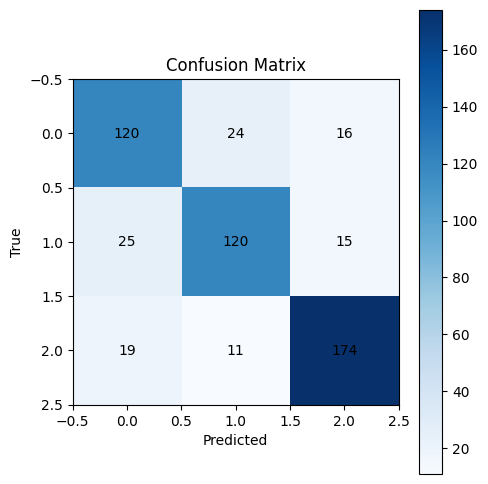

In [9]:
# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(5,5))
plt.imshow(cm, interpolation='nearest', cmap='Blues')
plt.title('Confusion Matrix'); plt.xlabel('Predicted'); plt.ylabel('True')
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, cm[i,j], ha='center', va='center')
plt.colorbar(); plt.tight_layout(); plt.show()

In [10]:
# End-to-End Pipeline + LIME Explanation
svc_tuned = SVC(
    probability=True,
    class_weight='balanced',
    **{k.split('__')[-1]: v for k,v in best_params.items() if k.startswith('clf__')},
    random_state=RANDOM_STATE
)
full_svm_pipe = Pipeline([
    ('stem',  FunctionTransformer(transform_stems, validate=False)),
    ('tfidf', TfidfVectorizer(**TFIDF_ARGS)),
    ('clf',   svc_tuned)
])
full_svm_pipe.fit(X_tr_raw, y_train)

Pipeline(steps=[('stem',
                 FunctionTransformer(func=<function transform_stems at 0x28380d4c0>)),
                ('tfidf',
                 TfidfVectorizer(max_features=3000, ngram_range=(1, 2),
                                 sublinear_tf=True,
                                 token_pattern='(?u)\\b\\w{3,}\\b')),
                ('clf',
                 SVC(C=10, class_weight='balanced', probability=True,
                     random_state=42))])

In [11]:
# Create LIME explainer: only split on whitespace (whole stems as tokens)
explainer = LimeTextExplainer(
    class_names=le.classes_,
    split_expression=r'\s+'
)

idx = 5
exp = explainer.explain_instance(
    X_te_raw.iloc[idx],
    full_svm_pipe.predict_proba,
    num_features=10,
    num_samples=300
)

# Print the top contributing stems
print("\nTop contributing stems:")
for tok, wt in exp.as_list():
    print(f"  {tok:>8s} → {wt:+.4f}")

# Display the interactive HTML highlights
display(HTML(exp.as_html()))


Top contributing stems:
   අතහැරලා → +0.3540
      යනවා → +0.2573
      ආදරේ → +0.1704
    කරගන්න → -0.0838
      හරිම → -0.0632
    විදියට → +0.0589
     විභාග → -0.0423
      හිස් → +0.0379
  ශිෂ්යයෙක් → +0.0378
       මාව → -0.0351


In [12]:
# Save Artifacts
with open('svm_pipeline.pkl','wb') as f:
    pickle.dump(full_svm_pipe, f)
with open('label_encoder_svm.pkl','wb') as f:
    pickle.dump(le, f)

print("All artifacts saved.")

All artifacts saved.


In [13]:
# Additional Diagnostic Plots
y_test_bin = label_binarize(y_test, classes=np.arange(len(le.classes_)))
probs = full_svm_pipe.predict_proba(X_te_raw)
colors = ['navy','darkorange','green']

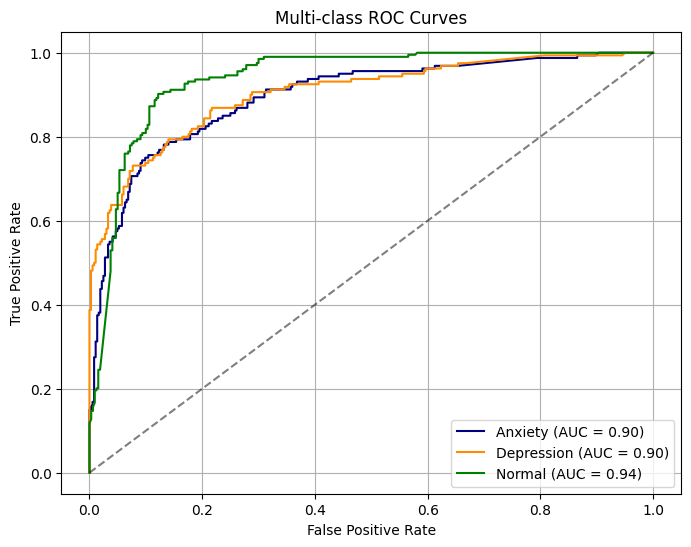

In [15]:
from sklearn.metrics import roc_curve, auc

# Multi-class ROC Curves
plt.figure(figsize=(8,6))
for i, col in enumerate(colors):
    fpr, tpr, _ = roc_curve(y_test_bin[:,i], probs[:,i])
    plt.plot(fpr, tpr, col,
             label=f"{le.classes_[i]} (AUC = {auc(fpr,tpr):.2f})")
plt.plot([0,1], [0,1], 'k--', alpha=0.5)
plt.title('Multi‑class ROC Curves')
plt.xlabel('False Positive Rate'); plt.ylabel('True Positive Rate')
plt.legend(loc='lower right'); plt.grid(True); plt.show()

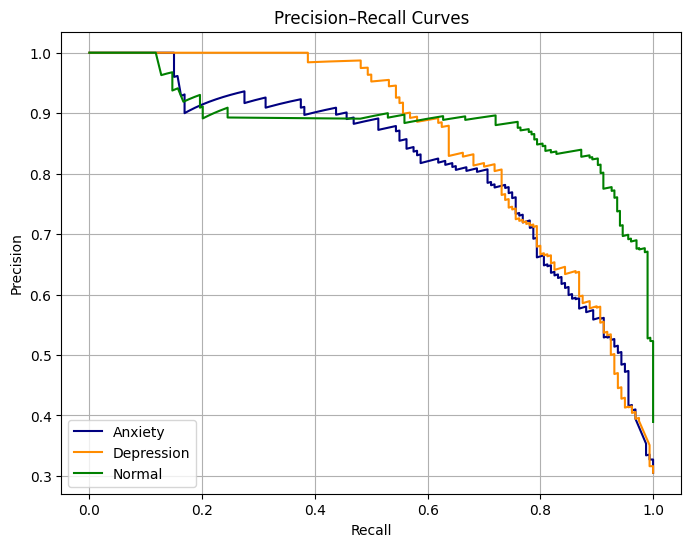

In [16]:
# Precision–Recall Curves
plt.figure(figsize=(8,6))
for i, col in enumerate(colors):
    precision, recall, _ = precision_recall_curve(
        y_test_bin[:,i], probs[:,i]
    )
    plt.plot(recall, precision, col,
             label=le.classes_[i])
plt.title('Precision–Recall Curves')
plt.xlabel('Recall'); plt.ylabel('Precision')
plt.legend(loc='lower left'); plt.grid(True); plt.show()

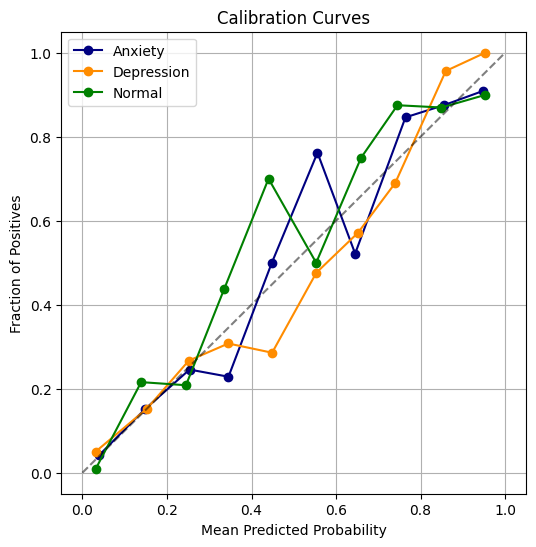

In [17]:
# Calibration Curves
plt.figure(figsize=(6,6))
for i, col in enumerate(colors):
    prob_true, prob_pred = calibration_curve(
        y_test_bin[:,i], probs[:,i], n_bins=10
    )
    plt.plot(prob_pred, prob_true, marker='o', color=col,
             label=le.classes_[i])
plt.plot([0,1], [0,1], 'k--', alpha=0.5)
plt.title('Calibration Curves')
plt.xlabel('Mean Predicted Probability'); plt.ylabel('Fraction of Positives')
plt.legend(); plt.grid(True); plt.show()

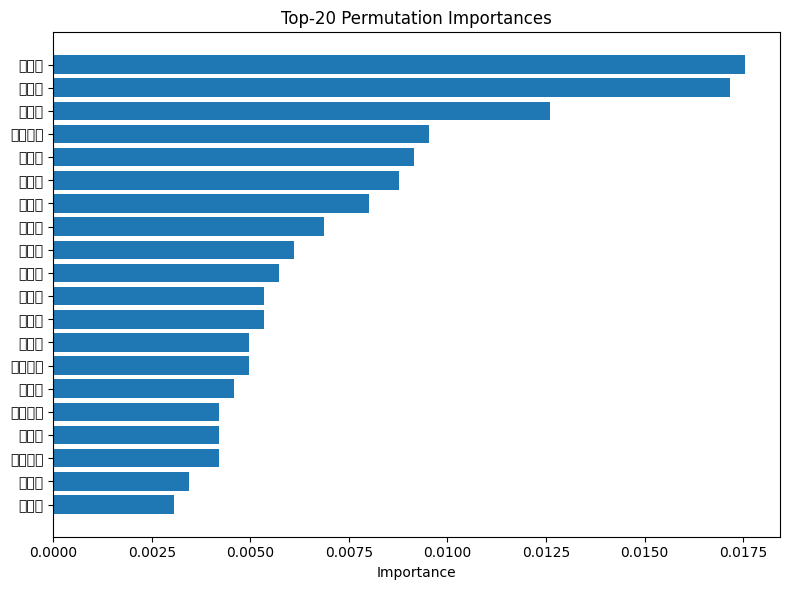

Feature # → Sinhala stem
 1: මතක
 2: දවස
 3: යවරය
 4: කවද
 5: ගහනව
 6: ඉවත
 7: කලබල
 8: ආතත
 9: පටන
10: දහඩ
11: ලනව
12: අතහ
13: කරග
14: ආදර
15: තරම
16: හවස
17: අඬනව
18: ටවත
19: කණස
20: කනස


In [18]:
# Top-20 Permutation Importances (Sinhala stems)
X_te_tfidf_dense = tfidf.transform(transform_stems(X_te_raw)).toarray()
perm = permutation_importance(
    full_svm_pipe.named_steps['clf'],
    X_te_tfidf_dense,
    y_test,
    n_repeats=5,
    random_state=RANDOM_STATE,
    n_jobs=-1
)
imps       = perm.importances_mean
feat_names = full_svm_pipe.named_steps['tfidf'].get_feature_names_out()
idxs       = np.argsort(imps)[-20:]

plt.figure(figsize=(8,6))
nums = np.arange(1,21)
plt.barh(nums[::-1], imps[idxs][::-1])
plt.yticks(nums[::-1], feat_names[idxs][::-1], fontsize=10)
plt.title('Top‑20 Permutation Importances')
plt.xlabel('Importance'); plt.tight_layout(); plt.show()

print("Feature # → Sinhala stem")
for num, name in zip(nums, feat_names[idxs]):
    print(f"{num:2d}: {name}")

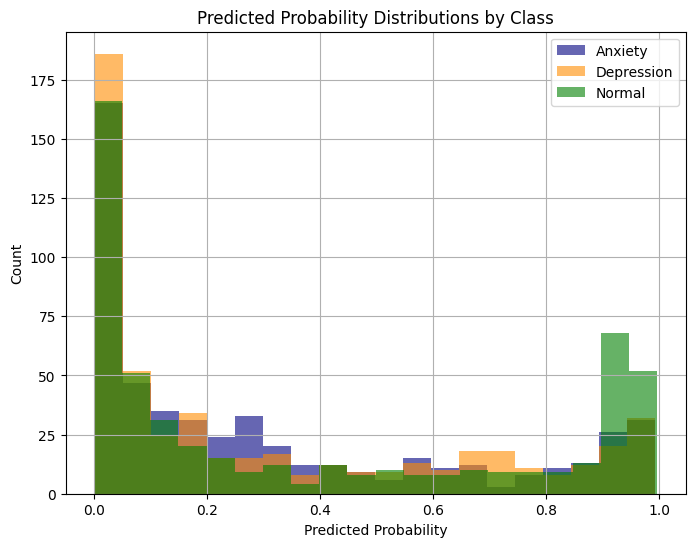

In [19]:
# Class Probability Histograms
plt.figure(figsize=(8,6))
for i, col in enumerate(colors):
    plt.hist(probs[:,i], bins=20, alpha=0.6, label=le.classes_[i], color=col)
plt.title('Predicted Probability Distributions by Class')
plt.xlabel('Predicted Probability'); plt.ylabel('Count')
plt.legend(); plt.grid(True); plt.show()